In [1]:
#extract file
import zipfile
zip_ref = zipfile.ZipFile('C:/Users/sandhya/Downloads/rossmann-store-sales.zip')
zip_ref.extractall()
zip_ref.close()

In [2]:
import pandas as pd
df = pd.read_csv('train.csv', low_memory=False)
df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [3]:
df.dtypes

Store             int64
DayOfWeek         int64
Date             object
Sales             int64
Customers         int64
Open              int64
Promo             int64
StateHoliday     object
SchoolHoliday     int64
dtype: object

In [4]:
#change columns to lowercase
df.columns=df.columns.str.lower()

In [5]:
#changing date to data time type from object and setting it as index
df['date']=pd.to_datetime(df['date'])
df.set_index('date',inplace=True)

In [6]:
df.dtypes

store             int64
dayofweek         int64
sales             int64
customers         int64
open              int64
promo             int64
stateholiday     object
schoolholiday     int64
dtype: object

<Axes: title={'center': 'Sales Data for Store 1'}, xlabel='date'>

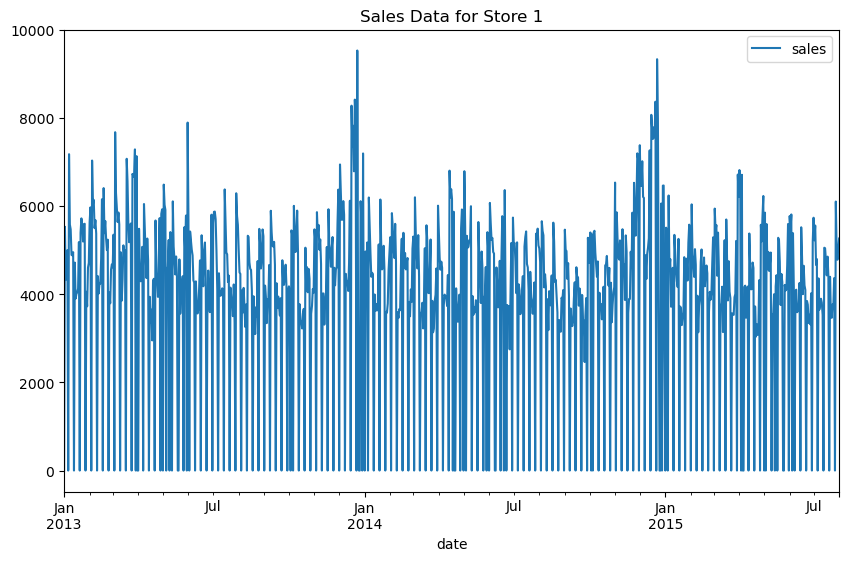

In [7]:
#taking data from a single store gives a boolean value if the value in the store is 1 to focus on a single store
store_df=df[df['store']==1].copy()
#selects sales columns for the store 1
store_df = store_df[['sales']]
#plot the sales for store 1
store_df.plot(figsize=(10, 6), title="Sales Data for Store 1")

<Axes: title={'center': 'Monthly Sales Data for Store 1'}, xlabel='date'>

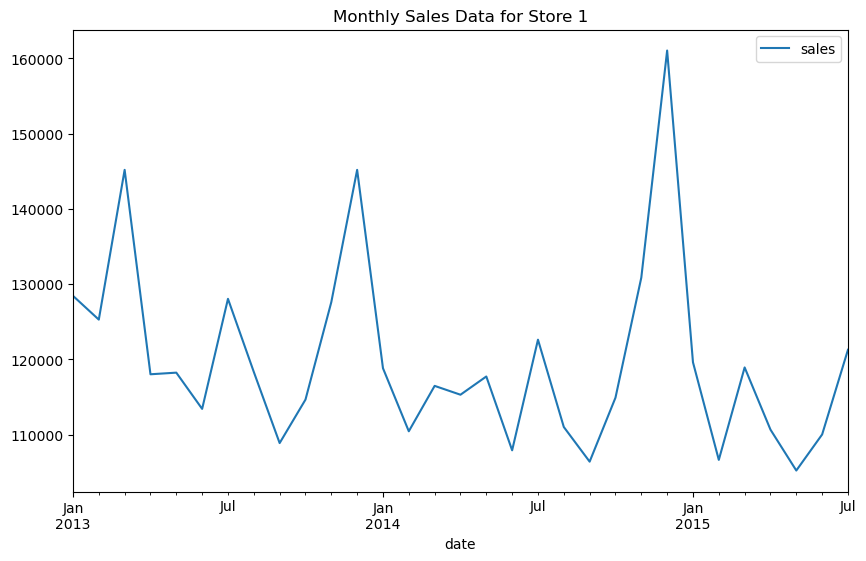

In [8]:
#Resampling data by month and plotting 
store_df = store_df.resample('M').sum()
store_df.plot(figsize=(10, 6), title="Monthly Sales Data for Store 1")

In [9]:
#checking for Stationarity using Augmented Dickey-Fuller(ADF) test
from statsmodels.tsa.stattools import adfuller
result= adfuller(store_df['sales'])
#test statistic and p-value if p-value < 0.05 series is staionary, or if p-value >= 0.05 it is not and we should make it stationary
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

ADF Statistic: -4.13884154250829
p-value: 0.0008348443914342278


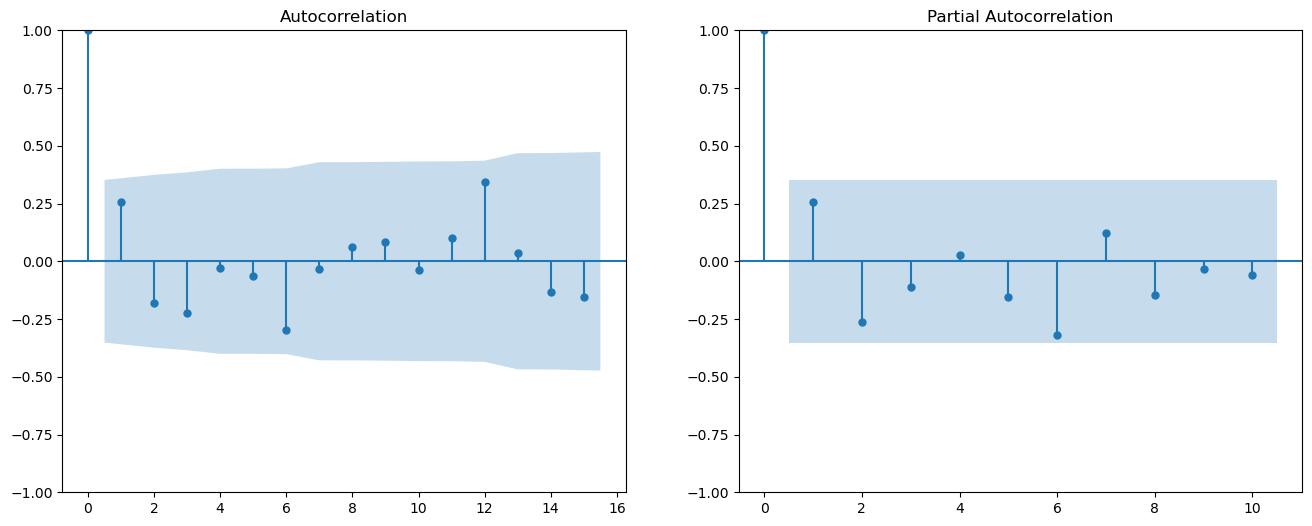

In [18]:
#building the ARIMA Model with p, d, and q parameters d=0 since it is stationary
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# Plot ACF and PACF
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
plot_acf(store_df['sales'], lags=15, ax=ax[0])
plot_pacf(store_df['sales'], lags=10, ax=ax[1])
plt.show()

In [15]:
print(store_df['sales'].isnull().sum())

0


                               SARIMAX Results                                
Dep. Variable:                  sales   No. Observations:                   31
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -334.257
Date:                Tue, 27 Aug 2024   AIC                            676.513
Time:                        23:04:38   BIC                            682.249
Sample:                    01-31-2013   HQIC                           678.383
                         - 07-31-2015                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.199e+05   3067.429     39.088      0.000    1.14e+05    1.26e+05
ar.L1         -0.1695      0.832     -0.204      0.839      -1.801       1.462
ma.L1          0.4950      0.751      0.659      0.5

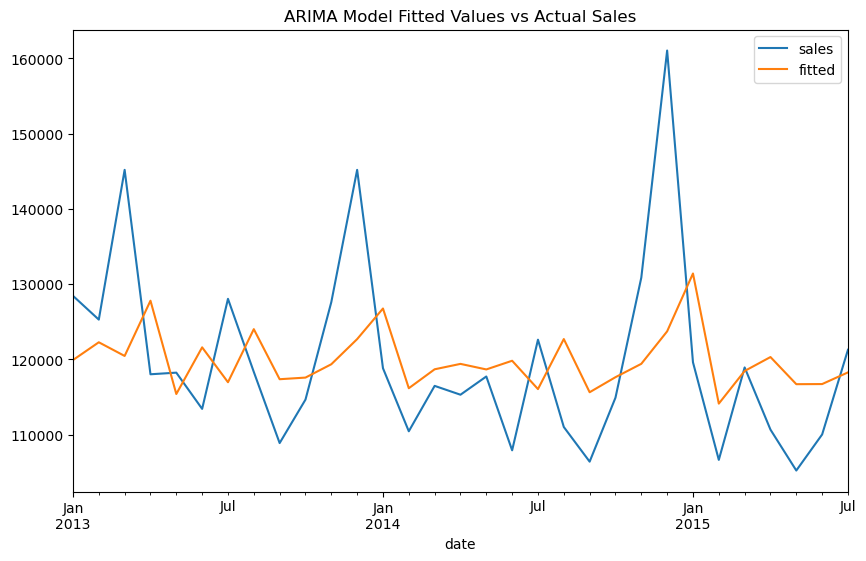

In [22]:
from statsmodels.tsa.arima.model import ARIMA

# Fit ARIMA model with (p, d=0, q)
model = ARIMA(store_df['sales'], order=(1, 0, 1))  # Set appropriate p and q values based on ACF and PACF (significant spike on lag 1 in the plot)
arima_result = model.fit()

# Print summary of the model
print(arima_result.summary())

# Plot the model's fitted values vs actual sales
store_df['fitted'] = arima_result.fittedvalues
store_df[['sales', 'fitted']].plot(figsize=(10, 6), title="ARIMA Model Fitted Values vs Actual Sales")
plt.show()


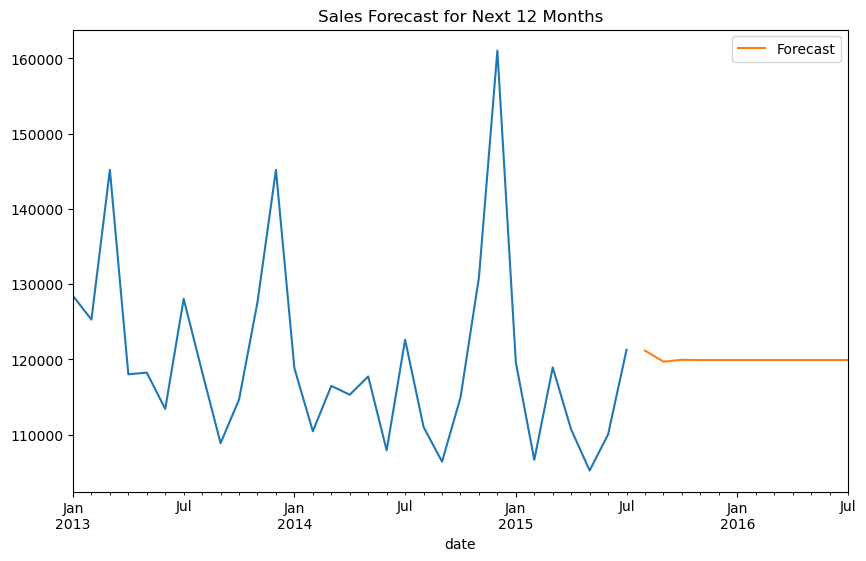

In [24]:
# Forecast the next 12 months
forecast = arima_result.get_forecast(steps=12)
forecast_index = pd.date_range(start=store_df.index[-1] + pd.DateOffset(1), periods=12, freq='M')
forecast_series = pd.Series(forecast.predicted_mean, index=forecast_index)

# Plot the forecast
store_df['sales'].plot(figsize=(10, 6), title="Sales Forecast for Next 12 Months")
forecast_series.plot(label='Forecast', legend=True)
plt.show()

In [25]:
# Combine forecasted data into a DataFrame
forecast_df = pd.DataFrame({
    'Date': forecast_index,
    'Forecasted_Sales': forecast_series
})

# Save the forecasted values to a CSV file
forecast_df.to_csv('forecasted_sales.csv', index=False)

print(forecast_df.head())  # Preview the first few rows of the forecasted values

                 Date  Forecasted_Sales
2015-08-31 2015-08-31     121155.020421
2015-09-30 2015-09-30     119685.561854
2015-10-31 2015-10-31     119934.608013
2015-11-30 2015-11-30     119892.399277
2015-12-31 2015-12-31     119899.552880
